In [21]:
import numpy as np
import pandas as pd
import random
import time
import math
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

### Define Site name and data source

Below is the only cell that the user needs to code.

First, name the site, such as "bulding_1"

Second, prepare your own `XXX.csv` data file and save it to `data/XXX.csv`. The csv file cannot have any missing data, and all data can be converted to float type. In the csv file, the first n-1 columns are inputs of the model. The nth column (last column) is the output of the model. There is no timestamp or index column in the csv. An example is shown below:

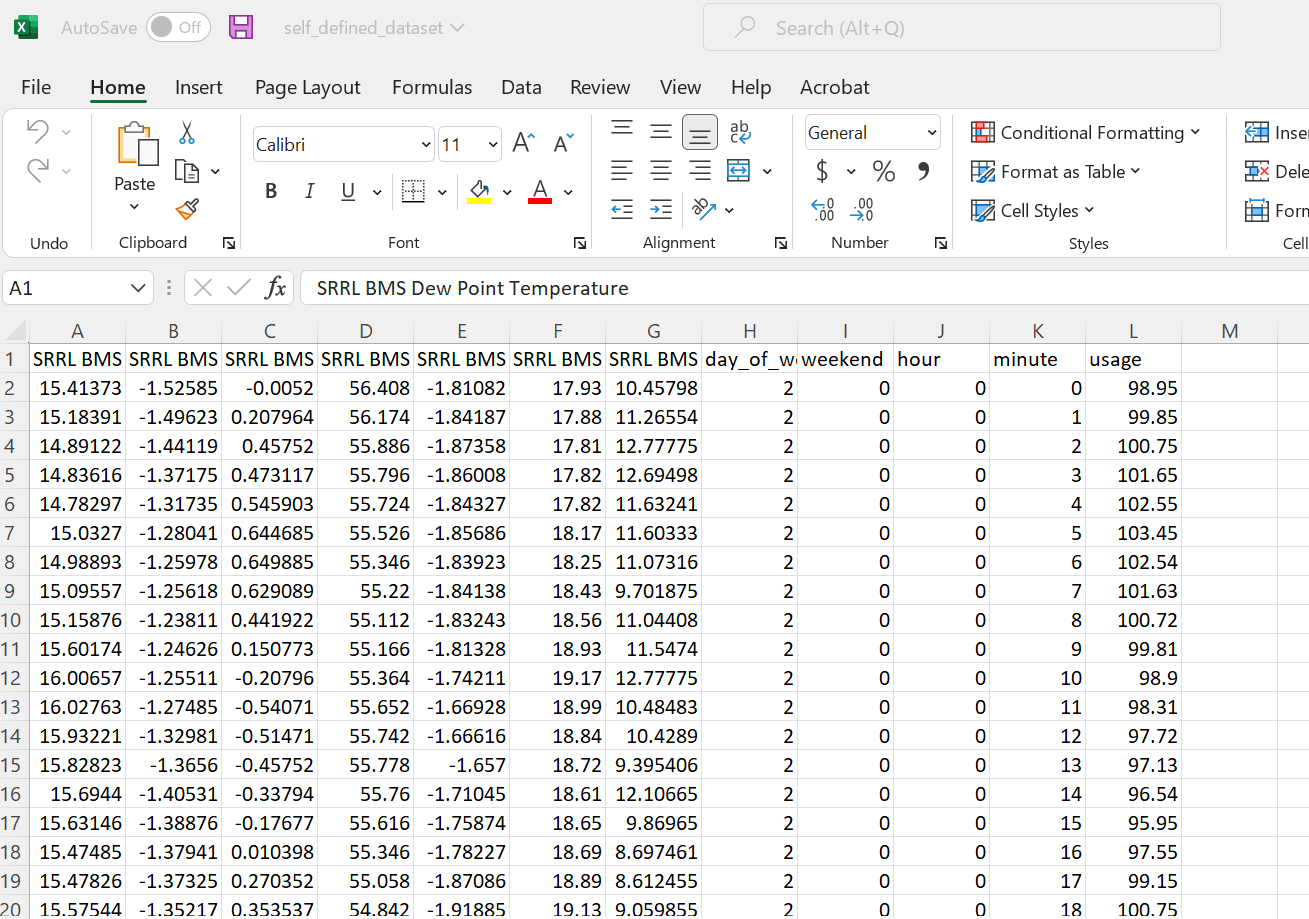

In [14]:
site = "self_defined"

# Load dataset
dataset = pd.read_csv("data/self_defined_dataset.csv").astype(np.float32)

### Postprocessing training data (train_source) and testing data (test_source)

In [15]:
epochs = 40
window_source_size = 3
window_target_size = 3

training_proportion = 0.8

# usage_actual = dataset['usage']
# mu_usage = dataset['usage'].mean()
# std_usage = dataset['usage'].std()
dataset = dataset.values

normalization = False

# Normalization
if normalization: 
    MU = dataset.mean(0) # 0 means take the mean of the column
    dataset = dataset - MU
    STD = dataset.std(0) # same with std here
    dataset = dataset / STD
else:
    MU = 0
    dataset = dataset - MU
    STD = 1
    dataset = dataset / STD

WINDOW_SOURCE_SIZE = window_source_size
WINDOW_TARGET_SIZE = window_target_size

# # getting actual usage vector, aligning with predicted values vector. Aka remove first window_source_size and remaining
# usage_actual = usage_actual.values
# usage_actual = usage_actual[int(dataset.shape[0]*0.80):]
# usage_actual = usage_actual[WINDOW_SOURCE_SIZE:]

# training testing split: 80% train, 20% test
train_source = dataset[:int(dataset.shape[0]*training_proportion)]
test_source = dataset[int(dataset.shape[0]*(1-training_proportion)):]

### Three types of S2S model structures with different attention model
class `S2S_Model`: vanilla S2S model without attention model

class `S2S_BA_Model`: S2S model with Bahdanau Attention model (https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)

class `S2S_LA_Model`: S2S model with Luong Attention module (https://machinelearningmastery.com/the-luong-attention-mechanism/). `attn` module is part of `S2S_LA_Model`

Each model structure can select RNN cell type, including `lstm`, `RNN`, `gru`

Three model structures are parallel. Each run defines one model structure. The selection of model structure is only used for sensitivity analysis and comparison study. In the future when we decide one model structure, we can delete the rest options.

In [16]:
#########################################################################################
# building the S2S model
class S2S_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(self.hidden_size, 1)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters. Refer to Saxe at al. paper that explains why to use orthogonal init weights
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # encoder forward function
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            h = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h

    def predict(self, pred_usage, h, target_length):
        # decoder forward function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h[0])
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#########################################################################################
# Bahdanau Attention model
# refer to : AuCson github code
# building the model
class S2S_BA_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_BA_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1+self.hidden_size, self.hidden_size)

        self.Wattn_energies = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.Wusage = nn.Linear(self.hidden_size, 1)
        self.Wout = nn.Linear(1+self.hidden_size*2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(self.hidden_size))
        stdv = 1./math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        self.init()

# function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.Wusage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.Wusage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h_copies = h.expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h, context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h_copies = h[0].expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h[0], context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#############################################################################################3
# Luong Attention module
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, " is not an appropriate attention method, please select one of dot, general, or concat.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        if self.method == 'concat':
            self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
            self.v = nn.Parameter(torch.rand(self.hidden_size))
            stdv = 1./math.sqrt(self.v.size(0))
            self.v.data.normal_(mean=0, std=stdv)

    def dot_score(self, hidden, encoder_output):
        attn_energies = torch.sum(hidden*encoder_output, dim=2)
        return attn_energies

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        attn_energies = torch.sum(hidden*energy, dim=2)
        return attn_energies

    def concat_score(self, hidden, encoder_output):
        energy = torch.tanh(self.attn(torch.cat((hidden.expand(encoder_output.shape[0], -1, -1),
                            encoder_output), 2)))
        return torch.sum(self.v * energy, dim=2)

    # calculate the attention weights (energies) based on the given method
    def forward(self, hidden, encoder_outputs):
        if self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)
        elif self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        attn_weights = torch.softmax(attn_energies, dim=1).unsqueeze(1)
        return attn_weights

#########################################################################################
#  building the S2S LA model
class S2S_LA_Model(nn.Module):
    def __init__(self, cell_type, attn_method, input_size, hidden_size, use_cuda):
        super(S2S_LA_Model, self).__init__()
        self.cell_type = cell_type
        self.attn_method = attn_method
        self.input_size = input_size
        self.hidden_size = hidden_size

        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(hidden_size, 1)
        self.lin_concat = nn.Linear(hidden_size*2, hidden_size)
        self.attn = Attn(self.attn_method, self.hidden_size)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.lin_usage(h)
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h, encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h, context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h[0], encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h[0], context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

### main function

The `S2S_Main` function process the data into three-dimensional for S2S model, train the model, and test the restuls

- def `generate_windows`: an important procedure to convert 2-dimensional data into 3-dimensional for modeling

- def `quantile_loss`: loss function with quntile number as parameter. For now, it cannot support list of quantiles as parameters.

In [17]:
# main function
def S2S_Main(seed, cuda, cell_type, attention_model, la_method, window_source_size,
            window_target_size, epochs, batch_size, hs, save_model, loss_function_qs, training_overlap, train_source, test_source):
    t0 = time.time()
    np.random.seed(seed)
    torch.manual_seed(seed)

    # loss function, qs here is an integer, not a list of integer
    def quantile_loss(output, target, qs, window_target_size):
        """
        Computes loss for quantile methods.
        :param output: (Tensor)
        :param target: (Tensor)
        :param qs: (int)
        :param window_target_size: (int)
        :return: (Tensor) Loss for this study (single number)
        """

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        resid = target - output
        tau = torch.tensor([qs], device=device).repeat_interleave(window_target_size)

        alpha = 0.001
        log_term = torch.zeros_like(resid, device=device)
        log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (
            resid[resid < 0] / alpha
        )
        log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
        loss = resid * tau + alpha * log_term
        loss = torch.mean(torch.mean(loss, 0))

        return loss
    
#     # Load dataset
#     if site == 'cafe':
#         dataset = pd.read_csv("data/Cafe_dataset_2.csv").astype(np.float32)
#     elif site == 'synthetic':
#         dataset = pd.read_csv("data/Synthetic Site_dataset_2.csv").astype(np.float32)        
#     else: 
#         raise Exception("The variable of 'site' should either be 'cafe' or 'synthetic'.")
        
#     usage_actual = dataset['usage']
#     mu_usage = dataset['usage'].mean()
#     std_usage = dataset['usage'].std()
#     dataset = dataset.values
    

#     # Normalization
#     if normalization: 
#         print(f"Transforming data to 0 mean and unit var")
#         MU = dataset.mean(0) # 0 means take the mean of the column
#         dataset = dataset - MU
#         STD = dataset.std(0) # same with std here
#         dataset = dataset / STD
#     else:
#         MU = dataset.mean(0) # 0 means take the mean of the column
#         MU = 0
#         dataset = dataset - MU
#         STD = dataset.std(0) # same with std here
#         STD = 1
#         dataset = dataset / STD

#     print("Generating training and test data...")
#     WINDOW_SOURCE_SIZE = window_source_size
#     WINDOW_TARGET_SIZE = window_target_size

#     # getting actual usage vector, aligning with predicted values vector. Aka remove first window_source_size and remaining
#     usage_actual = usage_actual.values
#     usage_actual = usage_actual[int(dataset.shape[0]*0.80):]
#     usage_actual = usage_actual[WINDOW_SOURCE_SIZE:]

#     # training testing split: 80% train, 20% test
#     train_source = dataset[:int(dataset.shape[0]*0.80)]
#     test_source = dataset[int(dataset.shape[0]*0.80):]

    # A key function to convert from 2D data to 3D data. 
    def generate_windows():
        x_train = []
        y_usage_train = []
        x_test = []
        y_usage_test = []

        # for training data
#         idxs = np.random.choice(train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), replace=False)

#         for idx in idxs:
#             x_train.append(train_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, train_source.shape[1])) )
#             y_usage_train.append(train_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )
        
        if training_overlap == True:
            for i in range(1,WINDOW_TARGET_SIZE+1):
                idxs = np.arange(0, len(train_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), i)

                for idx in idxs:
                    x_train.append(train_source[idx:idx+WINDOW_SOURCE_SIZE, 0:-1].reshape((1, WINDOW_SOURCE_SIZE, train_source.shape[1]-1)) )
                    y_usage_train.append(train_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

            x_train = np.concatenate(x_train, axis=0) # make them arrays and not lists
            y_usage_train = np.concatenate(y_usage_train, axis=0)

            # for testing data
            idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)

            for idx in idxs:
                x_test.append(test_source[idx:idx+WINDOW_SOURCE_SIZE,0:-1].reshape((1, WINDOW_SOURCE_SIZE, test_source.shape[1]-1)) )
                y_usage_test.append(test_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

    #         idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+2), 1)

    #         for idx in idxs:
    #             x_test.append(test_source[idx:idx+WINDOW_SOURCE_SIZE, 0:-1].reshape((1, WINDOW_SOURCE_SIZE, test_source.shape[1]-1)) )
    #             y_usage_test.append(test_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        if training_overlap == False:
            # for training data
            idxs = np.random.choice(train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), replace=False)

            for idx in idxs:
                x_train.append(train_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, train_source.shape[1])) )
                y_usage_train.append(train_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

            x_train = np.concatenate(x_train, axis=0) # make them arrays and not lists
            y_usage_train = np.concatenate(y_usage_train, axis=0)

            # for testing data
            idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)

            for idx in idxs:
                x_test.append(test_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, test_source.shape[1])) )
                y_usage_test.append(test_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_test = np.concatenate(x_test, axis=0) # make them arrays and not lists
        y_usage_test = np.concatenate(y_usage_test, axis=0)

        return x_train, y_usage_train, x_test, y_usage_test

    X_train, Y_train_usage, X_test, Y_test_usage = generate_windows()
    print("Created {} train samples and {} test samples".format(X_train.shape[0], X_test.shape[0]))
    idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)
    remainder = len(test_source) - (idxs[-1] + WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE)
    usage_actual = dataset[:,-1][:-remainder]

#################################################################################################################################################
# call the model
    #print("Creating model...")
    INPUT_SIZE = X_train.shape[-1]
    HIDDEN_SIZE = hs
    CELL_TYPE = cell_type
    LA_METHOD = la_method

    # call the respective model
    if attention_model == 'none':
        model = S2S_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'BA':
        model = S2S_BA_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'LA':
        model = S2S_LA_Model(CELL_TYPE, LA_METHOD, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    if cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model.cuda()

    print("MODEL ARCHITECTURE IS: ")
    print(model)

    print("\nModel parameters are on cuda: {}".format(next(model.parameters()).is_cuda))

    opt = optim.Adam(model.parameters(), lr=1e-3)
#     loss_fn = nn.MSELoss(reduction='sum')
    loss_fn = quantile_loss
    
    EPOCHES = epochs
    BATCH_SIZE = batch_size

    print("\nStarting training...")

    train_loss = []
    test_loss = []

    for epoch in range(EPOCHES):
        t_one_epoch = time.time()
        print("Epoch {}".format(epoch+1))
        total_usage_loss = 0
        for b_idx in range(0, X_train.shape[0], BATCH_SIZE):

            x = torch.from_numpy(X_train[b_idx:b_idx+BATCH_SIZE]).float()
            y_usage = torch.from_numpy(Y_train_usage[b_idx:b_idx+BATCH_SIZE]).float()

            if cuda:
                x = x.cuda()
                y_usage = y_usage.cuda()

            # encoder forward, for respective models (with and without attention)
            if attention_model == 'none':
                pred_usage, h = model.consume(x)

            elif attention_model == 'BA':
                pred_usage, h, encoder_outputs = model.consume(x)

            elif attention_model == 'LA':
                pred_usage, h, encoder_outputs = model.consume(x)

            # decoder forward, for respective models
            if attention_model == 'none':
                preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

            elif attention_model == 'BA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            elif attention_model == 'LA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            # compute lose
            loss_usage = loss_fn(preds, y_usage, qs = loss_function_qs, window_target_size=window_target_size)

            # backprop and update
            opt.zero_grad()

            loss_usage.sum().backward()

            opt.step()

#             total_usage_loss += loss_usage.item()
            
        train_loss.append(total_usage_loss)
#         print("\tTRAINING: {} total train USAGE loss.\n".format(total_usage_loss))

#################################################################################################################################################
# TESTING
        y_usage = None
        pred_usage = None
        preds = None
        total_usage_loss = 0
        all_preds = []

        for b_idx in range(0, X_test.shape[0], BATCH_SIZE):
            with torch.no_grad():
                x = torch.from_numpy(X_test[b_idx:b_idx+BATCH_SIZE])
                y_usage = torch.from_numpy(Y_test_usage[b_idx:b_idx+BATCH_SIZE])

                if cuda:
                    x = x.cuda()
                    y_usage = y_usage.cuda()

                # encoder forward, for respective models
                if attention_model == 'none':
                    pred_usage, h = model.consume(x)

                elif attention_model == 'BA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                elif attention_model == 'LA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                # decoder forward, for respective models
                if attention_model == 'none':
                    preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

                elif attention_model == 'BA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                elif attention_model == 'LA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                # compute loss
                loss_usage = loss_fn(preds, y_usage, qs = loss_function_qs, window_target_size=window_target_size)

                if (epoch == epochs-1):
                    all_preds.append(preds)

        test_loss.append(total_usage_loss)

#         print("\tTESTING: {} total test USAGE loss".format(total_usage_loss))
#         print("\tTESTING:\n")
        print("\tSample of prediction:")
        print("\t\t TARGET: {}".format(y_usage[-1].cpu().detach().numpy().flatten()))
        print("\t\t   PRED: {}\n\n".format(preds[-1].cpu().detach().numpy().flatten()))

        y_last_usage = y_usage[-1].cpu().detach().numpy().flatten()
        pred_last_usage = preds[-1].cpu().detach().numpy().flatten()
        t2_one_epoch = time.time()
        time_one_epoch = t2_one_epoch - t_one_epoch
        print("TIME OF ONE EPOCH: {} seconds and {} minutes".format(time_one_epoch, time_one_epoch/60.0))

####################################################################################################
# SAVING MODEL
    if save_model:
        torch.save(model.state_dict(), "MODEL_w:__seed={}_cell_type={}_attention_model={}_la_method={}_T={}_N={}_bs={}_hs={}".format(
            seed, cell_type, attention_model, la_method,
            window_source_size, window_target_size, batch_size, hs))

#################################################################################################################################################
# RESULTS
    # for plotting and accuracy
    preds = torch.cat(all_preds, 0)
    preds = preds.cpu().detach().numpy().flatten()
    actual = Y_test_usage.flatten()

    # for loss plotting
    train_loss_array = np.asarray(train_loss)
    test_loss_array = np.asarray(test_loss)
    len_loss = np.arange(len(train_loss_array))

#     # unnormalizing 1
#     if normalization:
#         preds_unnorm = (preds*std_usage) + mu_usage
#     else:
#         preds_unnorm = preds

    # using the actual usage from top of script here
#     mae3 = (sum(abs(usage_actual - preds_unnorm)))/(len(usage_actual))
#     mape3 = (sum(abs((usage_actual - preds_unnorm)/usage_actual)))/(len(usage_actual))
    mae3 = 0
    mape3 = 0

    # for std
#     mape_s = (abs((usage_actual - preds_unnorm)/usage_actual))
    mape_s = 0
#     s = mape_s.std()
    s = 0
#     mae_s = abs(usage_actual - preds_unnorm)
    mae_s = 0
#     s2 = mae_s.std()
    s2 = 0
    print("\n\tACTUAL ACC. RESULTS: MAE, MAPE: {} and {}%".format(mae3, mape3*100.0))
    
    if not os.path.exists(f'results/{site}'):
        os.makedirs(f'results/{site}')
    
    pd.DataFrame(preds, columns = [f'q{loss_function_qs}']).to_csv(f'results/{site}/q{loss_function_qs}.csv', index = None)
    pd.DataFrame(actual, columns = [f'actual']).to_csv(f'results/{site}/actual.csv', index = None)

    # total time of run
    t1 = time.time()
    total = t1-t0
    print("\nTIME ELAPSED: {} seconds OR {} minutes".format(total, total/60.0))
    print("\nEnd of run")
    plt.show()
#     for_plotting = [usage_actual, preds_unnorm, y_last_usage, pred_last_usage]
    return s, s2, mape_s, mae_s, mae3, mape3, total/60.0, train_loss, test_loss, MU, STD

### Model Training and Testing

In [18]:
# Run training and testing

for loss_function_qs in [0.05, 0.25, 0.50, 0.75, 0.95]: #[0.50]:#[0.05, 0.50, 0.95]:
    print(f"Processing loss function alpha: {loss_function_qs}")
    s, s2, mape_s, mae_s, mae, mape, total_mins, train_loss, test_loss, MU, STD = S2S_Main(seed=42, cuda=False,
        cell_type='rnn', attention_model='BA', la_method='none',
        window_source_size=window_source_size, window_target_size=window_target_size, epochs=epochs,
        batch_size=256*4, hs=64*1, save_model=False, loss_function_qs = loss_function_qs, training_overlap = True, train_source = train_source, test_source = test_source)

Processing loss function alpha: 0.05
Created 14766 train samples and 2685 test samples
MODEL ARCHITECTURE IS: 
S2S_BA_Model(
  (Ecell): RNNCell(11, 64)
  (Dcell): RNNCell(65, 64)
  (Wattn_energies): Linear(in_features=128, out_features=64, bias=True)
  (Wusage): Linear(in_features=64, out_features=1, bias=True)
  (Wout): Linear(in_features=129, out_features=64, bias=True)
)

Model parameters are on cuda: False

Starting training...
Epoch 1
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 8.803765 10.198361 10.412219]


TIME OF ONE EPOCH: 0.49189114570617676 seconds and 0.008198185761769613 minutes
Epoch 2
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [25.001392 32.835857 33.58557 ]


TIME OF ONE EPOCH: 0.4498131275177002 seconds and 0.007496885458628337 minutes
Epoch 3
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [48.85775 76.37181 87.32478]


TIME OF ONE EPOCH: 0.4231555461883545 seconds and 0.00705259

	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 9.182481 10.548452 10.682119]


TIME OF ONE EPOCH: 0.41502881050109863 seconds and 0.006917146841684977 minutes
Epoch 2
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [25.544748 33.54731  34.298283]


TIME OF ONE EPOCH: 0.4858715534210205 seconds and 0.008097859223683675 minutes
Epoch 3
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [49.683506 77.62537  88.91836 ]


TIME OF ONE EPOCH: 0.4649503231048584 seconds and 0.00774917205174764 minutes
Epoch 4
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 62.510944  97.59558  110.18679 ]


TIME OF ONE EPOCH: 0.4531712532043457 seconds and 0.0075528542200724285 minutes
Epoch 5
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 67.80406   98.362625 105.27112 ]


TIME OF ONE EPOCH: 0.46446990966796875 seconds and 0.007741165161132812 minutes
Epoch 6
	Sample of predic

	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 9.193953 10.556018 10.69054 ]


TIME OF ONE EPOCH: 0.42724180221557617 seconds and 0.007120696703592936 minutes
Epoch 2
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [25.57108  33.585167 34.337036]


TIME OF ONE EPOCH: 0.4009134769439697 seconds and 0.006681891282399496 minutes
Epoch 3
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [49.748505 77.72155  89.04108 ]


TIME OF ONE EPOCH: 0.4327073097229004 seconds and 0.007211788495381673 minutes
Epoch 4
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 71.026184 119.82952  145.25174 ]


TIME OF ONE EPOCH: 0.4657564163208008 seconds and 0.007762606938680013 minutes
Epoch 5
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 70.230606  99.70369  109.00393 ]


TIME OF ONE EPOCH: 0.6275498867034912 seconds and 0.01045916477839152 minutes
Epoch 6
	Sample of predicti

	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 9.197671 10.558215 10.693024]


TIME OF ONE EPOCH: 0.42418384552001953 seconds and 0.007069730758666992 minutes
Epoch 2
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [25.579342 33.59687  34.34895 ]


TIME OF ONE EPOCH: 0.4347987174987793 seconds and 0.007246645291646322 minutes
Epoch 3
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [49.768925 77.7516   89.0795  ]


TIME OF ONE EPOCH: 0.5643236637115479 seconds and 0.009405394395192465 minutes
Epoch 4
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 76.39599 136.68904 175.098  ]


TIME OF ONE EPOCH: 0.4848024845123291 seconds and 0.008080041408538819 minutes
Epoch 5
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 84.43035 134.61302 160.83159]


TIME OF ONE EPOCH: 0.48967742919921875 seconds and 0.008161290486653646 minutes
Epoch 6
	Sample of prediction:


	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 9.199218 10.559124 10.69405 ]


TIME OF ONE EPOCH: 0.4465024471282959 seconds and 0.007441707452138265 minutes
Epoch 2
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [25.582745 33.601665 34.353817]


TIME OF ONE EPOCH: 0.45714449882507324 seconds and 0.0076190749804178875 minutes
Epoch 3
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [49.77733 77.76395 89.09533]


TIME OF ONE EPOCH: 0.5231883525848389 seconds and 0.008719805876413982 minutes
Epoch 4
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [ 78.67619 144.54967 190.62814]


TIME OF ONE EPOCH: 0.47171807289123535 seconds and 0.007861967881520588 minutes
Epoch 5
	Sample of prediction:
		 TARGET: [104.9582 104.9148   8.0028]
		   PRED: [100.078705 187.4471   256.63443 ]


TIME OF ONE EPOCH: 0.39373350143432617 seconds and 0.006562225023905436 minutes
Epoch 6
	Sample of prediction

### self-defined data visualization

In [19]:
q95 = pd.read_csv(f'results/{site}/q0.95.csv')
q75 = pd.read_csv(f'results/{site}/q0.75.csv')
q50 = pd.read_csv(f'results/{site}/q0.5.csv')
q25 = pd.read_csv(f'results/{site}/q0.25.csv')
q05 = pd.read_csv(f'results/{site}/q0.05.csv')
actual = pd.read_csv(f'results/{site}/actual.csv')

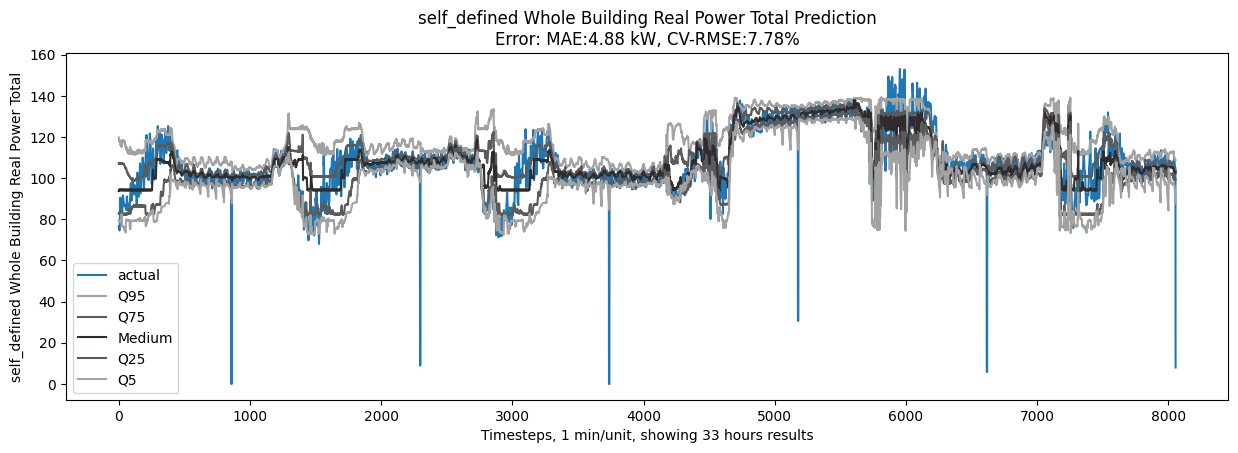

In [20]:
plt.figure(figsize=(15, 4.5))

# calculating error
y_actual = actual
y_predicted = q50.values.flatten()
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = MSE**0.5
CV_RMSE = RMSE/y_actual.mean().values[0]
mae = mean_absolute_error(y_actual, y_predicted)

plt.title(f'{site} Whole Building Real Power Total Prediction\nError: MAE:{mae:.2f} kW, CV-RMSE:{CV_RMSE*100:.2f}%')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

# plt.ylim(20,40)
# n=0
# plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 33 hours results')

plt.show()